## introduction
- keep content and only change style of image
- idea:
    - measure closeness of content and style respectively
    - layer closed to input captures specific, detailed features like edge, color, texture
    - layer closed to output captures high-dimensional conceptual features  
- build two networks
    - style transfer network (CAE)
        - returns style transfered image
    - loss network (VGG16)
        - given that style transfered image, calculates the loss of content and style
        - only used to train the network

In [1]:
import pickle
import datetime
import os
import math
import glob

import numpy as np

from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    BatchNormalization,
    Add,
    Activation,
    Input,
    Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adadelta

from utils import config_gpu, load_img, load_imgs
_ = config_gpu()

import matplotlib.pyplot as plt
%matplotlib inline

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### style transfer network
- similar to general CAE but,
    - does not use pooling layers
    - use residual block with skipped connection

In [2]:
def residual_block(input_ts):
    x = Conv2D(
        128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same'
    )(input_ts)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(
        128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same'
    )(x)
    x = BatchNormalization()(x)
    
    return Add()([x, input_ts])

In [3]:
def build_encoder_decoder(input_shape=(224, 224, 3)):
    
    # encoder
    input_ts = Input(shape=input_shape, name='input')
    x = Lambda(lambda x: x/255.)(input_ts)
    
    x = Conv2D(32, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # add 5 residual block
    for _ in range(5):
        x = residual_block(x)
    
    # decoder
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    # scale pixel value to [0, 255] (tanh returns (-1, 1))
    gen_out = Lambda(lambda x: (x+1)*127.5)(x)
    
    model_gen = Model(
        inputs=[input_ts],
        outputs=[gen_out]
    )
    
    return model_gen

In [4]:
input_shape = (224, 224, 3)

In [5]:
model_gen = build_encoder_decoder(input_shape)

### loss network
- use pre-trained VGG16 but
    - returns features calculated in middle layer

| element | layer name|
| :--| :--|
|content | block3_conv3
| style | block1_conv2, block2_conv2, block3_conv3, block4_conv3|

In [6]:
# load pre-trained VGG16
vgg16 = VGG16()

# does not allow re-training the weights
for layer in vgg16.layers:
    layer.trainable = False

In [7]:
# preprocess input features using vgg16
# 1. RGB -> GBR
# 2. centering
def norm_vgg16(x):
    return (x[:, :, :, ::-1] - 120) / 255.

In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# names for layers extracting features
style_layer_names = (
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
)
content_layer_names = (
    'block3_conv3',
)

In [10]:
# preserves outputs of middle layer
style_outputs_gen = []
content_outputs_gen = []

In [11]:
# pass output image of style-transfer network as a input image
input_gen = model_gen.output

In [12]:
# normalize input image
z = Lambda(norm_vgg16)(input_gen)

In [13]:
for layer in vgg16.layers:
    z = layer(z)
    if layer.name in style_layer_names:
        style_outputs_gen.append(z)
    if layer.name in content_layer_names:
        content_outputs_gen.append(z)

In [14]:
model = Model(
    inputs=model_gen.input,
    outputs=style_outputs_gen + content_outputs_gen
)

### data preparation

| element | image | # of image |
| :-- | :-- | :-- |
| style | Piet Mondriaan | 1 |
| content | Input Image | # of input image |

In [15]:
input_size = input_shape[:2]

In [16]:
img_sty = load_img(
    '../data/chap11/img/style/Piet_Mondrian_Composition.png',
    target_size=input_size
)

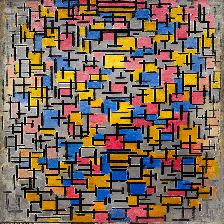

In [17]:
img_sty

In [18]:
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0)

In [19]:
# extract style features from true image
input_sty = Input(shape=input_shape, name='input_sty')
style_outputs = []
x = Lambda(norm_vgg16)(input_sty)

for layer in vgg16.layers:
    x = layer(x)
    if layer.name in style_layer_names:
        style_outputs.append(x)

model_sty = Model(
    inputs=input_sty,
    outputs=style_outputs
)

y_true_sty = model_sty.predict(img_arr_sty)

In [20]:
# extract content features from true image
input_con = Input(shape=input_shape, name='input_con')
content_outputs = []
y = Lambda(norm_vgg16)(input_con)

for layer in vgg16.layers:
    y = layer(y)
    if layer.name in content_layer_names:
        content_outputs.append(y)

model_con = Model(
    inputs=input_con,
    outputs=content_outputs
)

In [21]:
def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
    n_samples = len(img_paths)
    indices = list(range(n_samples))
    steps_per_epoch = math.ceil(n_samples / batch_size)
    img_paths = np.array(img_paths)
    cnt_epoch = 0
    while True:
        cnt_epoch += 1
        if shuffle:
            np.random.shuffle(indices)
        for i in range(steps_per_epoch):
            start = batch_size*i
            end = batch_size*(i+1)
            X = load_imgs(img_paths[indices[start:end]], input_size)
            batch_size_act = X.shape[0]
            y_true_sty_t = [
                np.repeat(feat, batch_size_act, axis=0)                
                for feat in y_true_sty
            ]
            # exrtract content
            y_true_con = model.predict(X)
            yield (X, y_true_sty_t + [y_true_con])
            
        if epochs is not None:
            if cnt_epoch >= epochs:
                raise StopIteration

In [22]:
path_glob = os.path.join('../data/chap11/img/context/*.jpg')

In [23]:
img_paths = glob.glob(path_glob)

In [24]:
batch_size = 2
epochs = 10

In [25]:
gen = train_generator(
    img_paths,
    batch_size,
    model_con,
    y_true_sty,
    epochs=epochs
)

In [26]:
# content loss
def feature_loss(y_true, y_pred):
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
    return K.sum(K.square(y_pred - y_true), axis=(1, 2, 3)) / norm

In [27]:
# gram matrix
def gram_matrix(X):
    
    # like np.transform
    X_sw = K.permute_dimensions(
        X, (0, 3, 2, 1)
    )
    # like np.reshape
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2]*s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0, 2, 1)
    )
    dot = K.batch_dot(X_rs, X_rs_t)
    norm = K.prod(K.cast(s[1:], 'float32'))
    
    return dot/norm

In [28]:
# style loss
def style_loss(y_true, y_pred):
    return K.sum(K.square(gram_matrix(y_pred) - gram_matrix(y_true)), axis=(1, 2))

In [29]:
# dt = datetime.datetime.now()
# run_time = str(dt.date()).replace('-', '') + str(dt.hour) + str(dt.minute)

# dir_log = '../model/style_transfer/log_{}'.format(run_time)
# dir_weights = '../model/style_transfer/weights_{}'.format(run_time)
# dir_gen_weights = '../model/style_transfer/gen_weights_{}'.format(run_time)
# dir_trans = '../model/style_transfer/trans_{}'.format(run_time)

# os.makedirs(dir_log, exist_ok=True)
# os.makedirs(dir_weights, exist_ok=True)
# os.makedirs(dir_gen_weights, exist_ok=True)
# os.makedirs(dir_trans, exist_ok=True)

In [30]:
model.compile(
    optimizer=Adadelta(),
    loss=[
        style_loss,
        style_loss,
        style_loss,
        style_loss,
        feature_loss
    ],
    loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

In [31]:
# save immediate style-transfered result during training time
img_test = load_img(
    '../data/chap11/img/test/building.jpg',
    target_size=input_size
)

In [32]:
img_arr_test = img_to_array(img_test)

In [33]:
img_arr_test = np.expand_dims(img_to_array(img_test), axis=0)

In [34]:
# minibatch steps
steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

In [35]:
# run model
now_epoch = 11
losses = []
path_tmp = 'epoch_{}_iters_{}_losses_{:.2f}_{}'

In [36]:
dir_log = '../model/style_transfer/log_202002161448/'
dir_trans = '../model/style_transfer/trans_202002161448/'
dir_weights = '../model/style_transfer/weights_202002161448/'
dir_gen_weights = '../model/style_transfer/gen_weights_202002161448/'

model.load_weights(
    '../model/style_transfer/weights_202002161448/epoch_10_iters_48150_losses_423.72_.h5'
)
model_gen.load_weights(
    '../model/style_transfer/gen_weights_202002161448/epoch_10_iters_48150_losses_423.72_.h5'
)

* takes about 2.5 hours

In [37]:
for i, (x_train, y_train) in enumerate(gen):
    
    if i % steps_per_epoch == 0:
        now_epoch += 1
        
    # training
    loss = model.train_on_batch(x_train, y_train)
    losses.append(loss)
    
    # print training progressing result
    if i % iters_verbose == 0:
        print('epoch: {}, iters: {}, loss: {:.3f}'.
              format(now_epoch, i, loss[0]))
        
    # save image
    if i % iters_save_img == 0:
        pred = model_gen.predict(img_arr_test)
        img_pred = array_to_img(pred.squeeze())
        path_trs_img = path_tmp.format(
            now_epoch, i, loss[0], '.jpg'
        )
        img_pred.save(
            os.path.join(dir_trans, path_trs_img)
        )
        print('# image saved: {}'.format(path_trs_img))
    
    # save model, losses
    if i % iters_save_model == 0:
        model.save(
            os.path.join(
                dir_weights,
                path_tmp.format(now_epoch, i, loss[0], '.h5')
            )
        )
        model_gen.save(
            os.path.join(
                dir_gen_weights,
                path_tmp.format(now_epoch, i, loss[0], '.h5')
            )
        )
        path_loss = os.path.join(dir_log, 'loss.pkl')
        with open(path_loss, 'wb') as f:
            pickle.dump(losses, f)

epoch: 12, iters: 0, loss: 447.390
# image saved: epoch_12_iters_0_losses_447.39_.jpg
epoch: 12, iters: 1000, loss: 412.504
# image saved: epoch_12_iters_1000_losses_412.50_.jpg
epoch: 12, iters: 2000, loss: 444.901
# image saved: epoch_12_iters_2000_losses_444.90_.jpg
epoch: 12, iters: 3000, loss: 441.442
# image saved: epoch_12_iters_3000_losses_441.44_.jpg
epoch: 12, iters: 4000, loss: 495.341
# image saved: epoch_12_iters_4000_losses_495.34_.jpg
epoch: 12, iters: 5000, loss: 458.014
# image saved: epoch_12_iters_5000_losses_458.01_.jpg
epoch: 13, iters: 6000, loss: 416.819
# image saved: epoch_13_iters_6000_losses_416.82_.jpg
epoch: 13, iters: 7000, loss: 421.363
# image saved: epoch_13_iters_7000_losses_421.36_.jpg
epoch: 13, iters: 8000, loss: 486.468
# image saved: epoch_13_iters_8000_losses_486.47_.jpg
epoch: 13, iters: 9000, loss: 439.410
# image saved: epoch_13_iters_9000_losses_439.41_.jpg
epoch: 13, iters: 10000, loss: 446.565
# image saved: epoch_13_iters_10000_losses_446.

KeyboardInterrupt: 

## training result

In [63]:
model.load_weights('../model/style_transfer/weights_202002151855/epoch_10_iters_48150_losses_428.05_.h5')

In [43]:
with open('../model/style_transfer/log_202002151855/loss.pkl', 'rb') as f:
    losses = pickle.load(f)

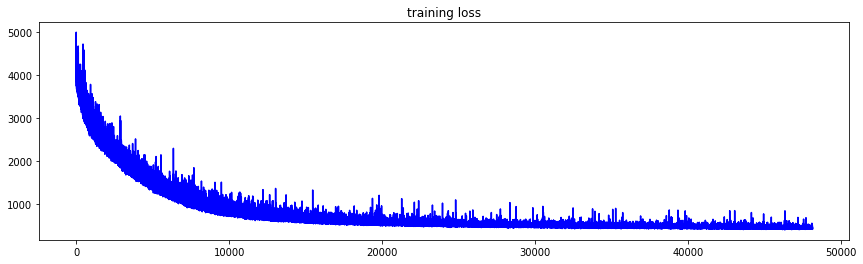

In [62]:
yticks = list(zip(*losses))[0]
xticks = range(len(yticks))

fig, ax = plt.subplots(1, 1)
ax.plot(xticks, yticks, color='blue')
ax.set_title('training loss')
fig.subplots_adjust(right=2)

In [85]:
img_paths = glob.glob('../model/style_transfer/trans_202002151855/*.jpg')

In [96]:
import pandas as pd
import re

In [101]:
img_paths[0]

'../model/style_transfer/trans_202002151855/epoch_2_iters_9000_losses_1130.88_.jpg'

In [151]:
data = pd.DataFrame(img_paths, columns=['path'])

In [152]:
data['epoch'] = data.path.apply(lambda x: int(re.findall('epoch_[0-9.]*_', x)[0].split('_')[1]))
data['iters'] = data.path.apply(lambda x: int(re.findall('iters_[0-9.]*_', x)[0].split('_')[1]))
data['losses'] = data.path.apply(lambda x: float(re.findall('losses_[0-9.]*_', x)[0].split('_')[1]))

In [157]:
data = data.sort_values(['epoch', 'iters', 'losses']).reset_index(drop=True)

In [159]:
pred_imgs = load_imgs(data.path.tolist(), input_shape)

In [160]:
pred_imgs = [array_to_img(pred_imgs[i]) for i in range(len(pred_imgs))]

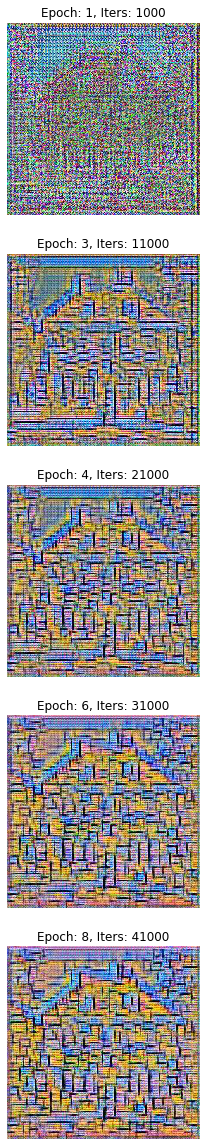

In [164]:
fig, ax_arr = plt.subplots(5, 1)
for i, idx in enumerate(range(1, 51, 10)):
    ax = ax_arr[i]
    ax.imshow(pred_imgs[idx])
    
    cur_epoch, cur_iters = data.loc[idx, ['epoch', 'iters']]
    ax.set_title('Epoch: {}, Iters: {}'.format(cur_epoch, cur_iters))
    ax.axis('off')
    
fig.subplots_adjust(right=2, top=4)

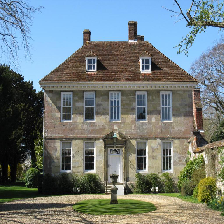

In [144]:
img_test